<a href="https://colab.research.google.com/github/UmaNagirireddi/RTML/blob/main/Rtml_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report, f1_score
import seaborn as sns

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
np.random.seed(123)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Create and download CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and std
mean, std = torch.stack([img_t.mean((1,2)) for img_t, _ in train_dataset]).mean(0), torch.stack([img_t.std((1,2)) for img_t, _ in train_dataset]).mean(0)


Files already downloaded and verified


In [ ]:
mean, std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2023, 0.1994, 0.2010]))

In [ ]:
cifar_10Val = datasets.CIFAR10(
     './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [ ]:
cifar_10 = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [ ]:
firstImage, label = cifar_10[0]
print(firstImage.shape)

torch.Size([3, 32, 32])


In [ ]:
trainLoader = DataLoader(cifar_10, batch_size=32, shuffle=True, num_workers=2)
testLoader = DataLoader(cifar_10Val, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
classNames = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [ ]:
class ModelNet(nn.Module):
    def __init__(self):
        super(ModelNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*3, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)  # 10 classes

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
model = ModelNet().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
Train_loss_list, val_loss_list, val_accuracy_list = [], [], []

epochs = 20
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(trainLoader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    Train_loss_list.append(running_loss / len(trainLoader))

    # Validation loop
    running_loss = 0.0
    correct = 0
    total = 0
    model.eval()
    all_predictions, all_targets = [], []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testLoader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.tolist())
            all_targets.extend(labels.tolist())

    val_loss_list.append(running_loss / len(testLoader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Training loss: {Train_loss_list[-1]:.4f}, Validation loss: {val_loss_list[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Epoch 1, Training loss: 1.7883, Validation loss: 1.5938, Validation Accuracy: 43.91%
Epoch 2, Training loss: 1.5413, Validation loss: 1.5082, Validation Accuracy: 46.96%
Epoch 3, Training loss: 1.4416, Validation loss: 1.4436, Validation Accuracy: 48.51%
Epoch 4, Training loss: 1.3721, Validation loss: 1.4146, Validation Accuracy: 50.31%
Epoch 5, Training loss: 1.3143, Validation loss: 1.4049, Validation Accuracy: 50.65%
Epoch 6, Training loss: 1.2667, Validation loss: 1.3881, Validation Accuracy: 51.21%
Epoch 7, Training loss: 1.2253, Validation loss: 1.4039, Validation Accuracy: 50.96%
Epoch 8, Training loss: 1.1857, Validation loss: 1.3960, Validation Accuracy: 50.74%
Epoch 9, Training loss: 1.1500, Validation loss: 1.4205, Validation Accuracy: 51.33%
Epoch 10, Training loss: 1.1184, Validation loss: 1.3649, Validation Accuracy: 52.72%
Epoch 11, Training loss: 1.0876, Validation loss: 1.3810, Validation Accuracy: 52.62%
Epoch 12, Training loss: 1.0602, Validation loss: 1.3982, Valid

In [ ]:
# Final evaluation
model.eval()
all_predictions, all_targets = [], []
with torch.no_grad():
    for i, (inputs, targets) in enumerate(testLoader, 0):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.tolist())
        all_targets.extend(targets.tolist())


In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(all_targets, all_predictions) * 100
precision, recall, f1 = precision_score(all_targets, all_predictions, average='weighted'), recall_score(all_targets, all_predictions, average='weighted'), f1_score(all_targets, all_predictions, average='weighted')

# Print the metrics
print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 52.559999999999995%
Precision: 0.5261513013756367
Recall: 0.5256
F1 Score: 0.5223713190250645


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 820874


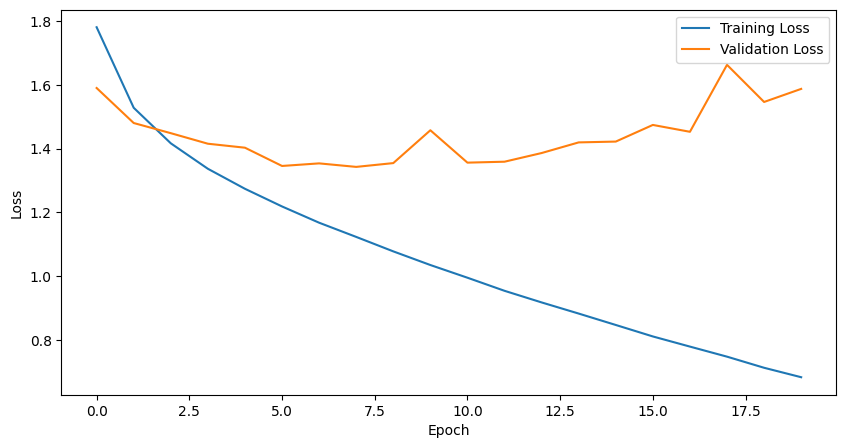

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(Train_loss_list , label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**1_B**

In [ ]:
class ModelNet(nn.Module):
    def __init__(self):
        super(ModelNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 128)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(128, 10)  # 10 classes

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
model = ModelNet().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
trainLossList, valLossList, valAccuracyList = [], [], []

for epoch in range(20):
    # Training loop
    model.train()
    trainLossList.append(sum(criterion(model(inputs.to(device)), labels.to(device)).item() for inputs, labels in trainLoader) / len(trainLoader))

    # Validation loop
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in testLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valLossList.append(val_loss / len(testLoader))
    valAccuracyList.append(100 * correct / total)

    print(f'Epoch {epoch + 1}, Training loss: {trainLossList[-1]}, Validation loss: {valLossList[-1]}, Validation Accuracy: {valAccuracyList[-1]}%')

trainLossList


Epoch 1, Training loss: 2.3023863302463914, Validation loss: 2.3020488019949332, Validation Accuracy: 11.08%
Epoch 2, Training loss: 2.30238108030894, Validation loss: 2.3020488019949332, Validation Accuracy: 11.08%
Epoch 3, Training loss: 2.302378831730389, Validation loss: 2.3020488019949332, Validation Accuracy: 11.08%
Epoch 4, Training loss: 2.3023782993690065, Validation loss: 2.3020488019949332, Validation Accuracy: 11.08%
Epoch 5, Training loss: 2.3023958201600587, Validation loss: 2.3020488019949332, Validation Accuracy: 11.08%
Epoch 6, Training loss: 2.302386080844999, Validation loss: 2.3020488019949332, Validation Accuracy: 11.08%
Epoch 7, Training loss: 2.302374482536194, Validation loss: 2.3020488019949332, Validation Accuracy: 11.08%
Epoch 8, Training loss: 2.3023722058904528, Validation loss: 2.3020488019949332, Validation Accuracy: 11.08%
Epoch 9, Training loss: 2.3023948710619146, Validation loss: 2.3020488019949332, Validation Accuracy: 11.08%
Epoch 10, Training loss:

[2.3023863302463914,
 2.30238108030894,
 2.302378831730389,
 2.3023782993690065,
 2.3023958201600587,
 2.302386080844999,
 2.302374482536194,
 2.3023722058904528,
 2.3023948710619146,
 2.302393759357113,
 2.3023802419541664,
 2.3023771101743535,
 2.302392960967578,
 2.3023856427527662,
 2.3023914247465225,
 2.30236987326287,
 2.3023795387490162,
 2.3023902357044084,
 2.30239627823491,
 2.302400454144713]

In [ ]:
allPredictions, allTargets = zip(*[(torch.max(model(inputs.to(device)).data, 1)[1].tolist(), targets.tolist()) for inputs, targets in testLoader])

# Flatten the nested lists
allPredictions = [item for sublist in allPredictions for item in sublist]
allTargets = [item for sublist in allTargets for item in sublist]



<Figure size 1000x800 with 0 Axes>

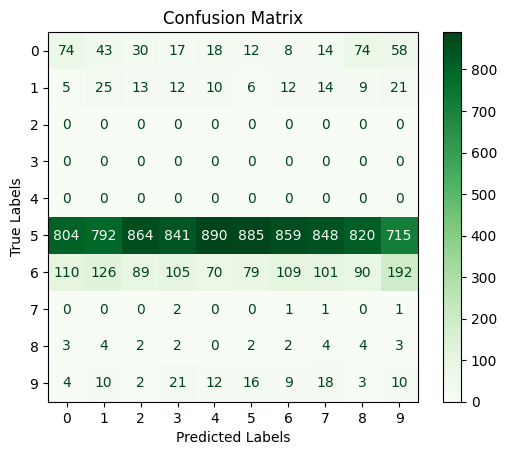

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(allPredictions, allTargets)
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(10))
plt.figure(figsize=(10, 8))
disp.plot(cmap="Greens", values_format="d")

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(allTargets, allPredictions) * 100
precision, recall, f1 = precision_score(allTargets, allPredictions, average='weighted'), recall_score(allTargets, allPredictions, average='weighted'), f1_score(allTargets, allPredictions, average='weighted')

# Print the metrics
print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 11.08%
Precision: 0.10667481321099824
Recall: 0.1108
F1 Score: 0.04772628092445849


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 1640330


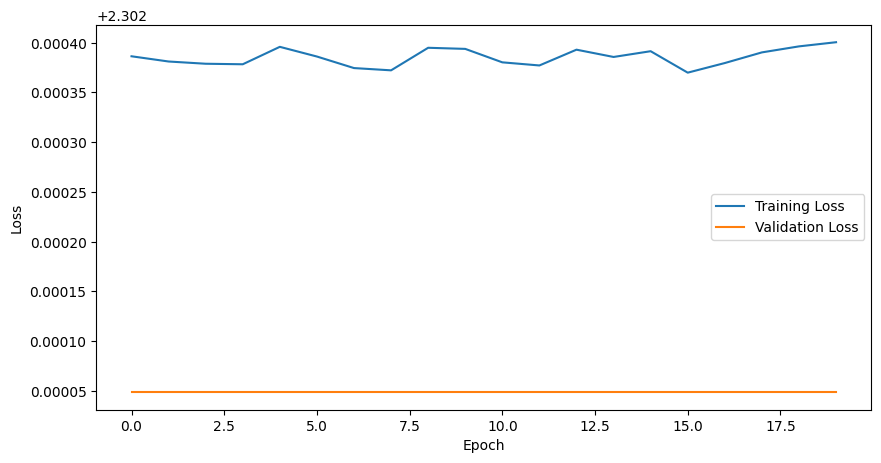

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(trainLossList, label='Training Loss')
plt.plot(valLossList, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**2_A**

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score

In [3]:
# Load dataset
df_train = pd.read_csv('/content/house-train.csv')
df_test = pd.read_csv('/content/house-test.csv')

# Define useful columns
useful_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath',
               'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'LotFrontage', 'WoodDeckSF',
               'OpenPorchSF']
target_col = 'SalePrice'

# Preprocess the dataset
df_train_prepro = df_train[useful_cols + [target_col]].copy()


In [6]:
df_train_prepro.fillna(df_train_prepro.mean(), inplace=True)

X, y = df_train_prepro[useful_cols], df_train_prepro[target_col]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled, X_val_scaled = scaler.fit_transform(X_train), scaler.transform(X_val)


In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors and create data loaders
train_loader = DataLoader(TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)), batch_size=32, shuffle=False)


In [11]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()

        # Define layers
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        # Forward pass
        x = self.relu(self.fc2(self.relu(self.fc1(x))))
        return self.fc4(self.fc3(x))


In [16]:
import torch.optim as optim

model = MLP(len(useful_cols))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        rmse_loss = torch.sqrt(criterion(output, y_batch))
        rmse_loss.backward()
        optimizer.step()
        total_loss += rmse_loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    y_pred, y_true, total_val_loss = [], [], 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            y_pred.extend(output.view(-1).tolist())
            y_true.extend(y_batch.view(-1).tolist())
            rmse_loss = torch.sqrt(criterion(output, y_batch))
            total_val_loss += rmse_loss.item()
    val_losses.append(total_val_loss / len(val_loader))

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


Epoch 1/100, Train Loss: 196804.0887, Val Loss: 196704.2219
Epoch 2/100, Train Loss: 196222.7563, Val Loss: 196592.7719
Epoch 3/100, Train Loss: 195838.4958, Val Loss: 195961.3797
Epoch 4/100, Train Loss: 194307.6119, Val Loss: 193702.9281
Epoch 5/100, Train Loss: 191225.1242, Val Loss: 187822.3734
Epoch 6/100, Train Loss: 182089.4561, Val Loss: 175321.5922
Epoch 7/100, Train Loss: 164611.5173, Val Loss: 152944.0109
Epoch 8/100, Train Loss: 136895.2016, Val Loss: 118990.8719
Epoch 9/100, Train Loss: 102531.2595, Val Loss: 82830.2895
Epoch 10/100, Train Loss: 79384.3606, Val Loss: 67089.4707
Epoch 11/100, Train Loss: 73345.3428, Val Loss: 63874.1977
Epoch 12/100, Train Loss: 70150.0765, Val Loss: 61665.4268
Epoch 13/100, Train Loss: 67776.3057, Val Loss: 59723.6727
Epoch 14/100, Train Loss: 67470.9779, Val Loss: 57419.4787
Epoch 15/100, Train Loss: 63018.5410, Val Loss: 55424.2031
Epoch 16/100, Train Loss: 60705.0023, Val Loss: 53481.1297
Epoch 17/100, Train Loss: 58393.8370, Val Loss: 

MSE: 1098892249.0786986
RMSE: 33149.543723537114
R² Score: 0.8567346134445974


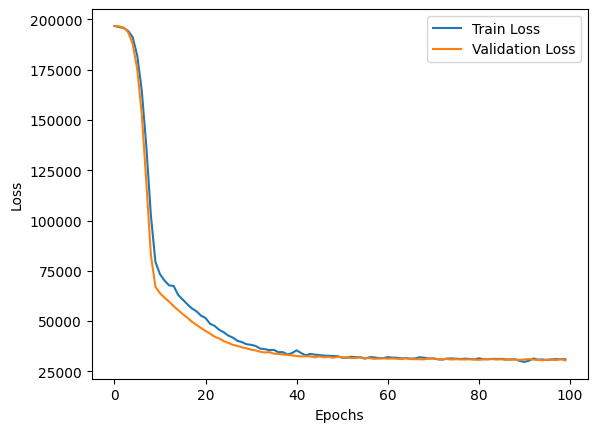

Total parameters: 11905


(None, None)

In [18]:
import matplotlib.pyplot as plt

mse, rmse, r2 = mean_squared_error(y_true, y_pred), mean_squared_error(y_true, y_pred)**0.5, r2_score(y_true, y_pred)
print(f'MSE: {mse}\nRMSE: {rmse}\nR² Score: {r2}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.legend(), plt.show()

total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}'), torch.save(model, 'model_complete.pth')


**2_B**

In [21]:
import numpy as np

# Select columns for training and preprocessing
df_train_prepro = df_train[useful_cols + [target_col]].copy()

# Identify numeric and categorical columns
numeric_cols, categorical_cols = df_train_prepro.select_dtypes(include=[np.number]).columns.tolist(), df_train_prepro.select_dtypes(exclude=[np.number]).columns.tolist()

# Fill missing values in numeric columns with mean
df_train_prepro[numeric_cols] = df_train_prepro[numeric_cols].fillna(df_train_prepro[numeric_cols].mean())

# Fill missing values in categorical columns with mode or a placeholder value
for col in categorical_cols: df_train_prepro[col] = df_train_prepro[col].fillna(df_train_prepro[col].mode()[0])

# One-hot encoding for categorical features
df_train_prepro = pd.get_dummies(df_train_prepro, columns=categorical_cols)

# Split dataset into features and target
X, y = df_train_prepro.drop(target_col, axis=1), df_train_prepro[target_col]


In [22]:
# Split data and scale features
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled, X_val_scaled = scaler.fit_transform(X_train), scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor, y_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor, y_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# Create data loaders
train_dataset, val_dataset = TensorDataset(X_train_tensor, y_train_tensor), TensorDataset(X_val_tensor, y_val_tensor)
train_loader, val_loader = DataLoader(train_dataset, batch_size=64, shuffle=True), DataLoader(val_dataset, batch_size=64, shuffle=False)


In [24]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc4(self.relu(self.fc3(self.relu(self.fc2(self.relu(self.fc1(x)))))))
        return x

model = MLP(X_train_tensor.shape[1])
criterion, optimizer = nn.MSELoss(), optim.Adam(model.parameters(), lr=0.001)


In [25]:
num_epochs, train_losses, val_losses = 100, [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = sum(torch.sqrt(criterion(model(X), y)).item() for X, y in train_loader)
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    avg_val_loss = sum(torch.sqrt(criterion(model(X), y)).item() for X, y in val_loader) / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


Epoch 1/100, Train Loss: 198369.0929, Val Loss: 199342.7656
Epoch 2/100, Train Loss: 195497.3331, Val Loss: 199342.7656
Epoch 3/100, Train Loss: 197542.7410, Val Loss: 199342.7656
Epoch 4/100, Train Loss: 197426.3520, Val Loss: 199342.7656
Epoch 5/100, Train Loss: 196963.5461, Val Loss: 199342.7656
Epoch 6/100, Train Loss: 196863.3956, Val Loss: 199342.7656
Epoch 7/100, Train Loss: 198228.7434, Val Loss: 199342.7656
Epoch 8/100, Train Loss: 197210.7730, Val Loss: 199342.7656
Epoch 9/100, Train Loss: 197839.4762, Val Loss: 199342.7656
Epoch 10/100, Train Loss: 196699.7681, Val Loss: 199342.7656
Epoch 11/100, Train Loss: 197375.2500, Val Loss: 199342.7656
Epoch 12/100, Train Loss: 196110.3890, Val Loss: 199342.7656
Epoch 13/100, Train Loss: 199439.9433, Val Loss: 199342.7656
Epoch 14/100, Train Loss: 196088.2113, Val Loss: 199342.7656
Epoch 15/100, Train Loss: 196376.2015, Val Loss: 199342.7656
Epoch 16/100, Train Loss: 196182.7878, Val Loss: 199342.7656
Epoch 17/100, Train Loss: 196703.

In [26]:
# Evaluation
model.eval()
y_pred, y_true = [], []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        y_pred.extend(model(X_batch).view(-1).tolist())
        y_true.extend(y_batch.view(-1).tolist())

mse, rmse, r2 = mean_squared_error(y_true, y_pred), (mean_squared_error(y_true, y_pred)) ** 0.5, r2_score(y_true, y_pred)

print(f'MSE: {mse}\nRMSE: {rmse}\nR² Score: {r2}')
print(f'Total parameters: {sum(p.numel() for p in model.parameters())}')
torch.save(model, 'model_complete.pth')


MSE: 39653953329.62663
RMSE: 199133.00411942424
R² Score: -4.169787080563891
Total parameters: 11905


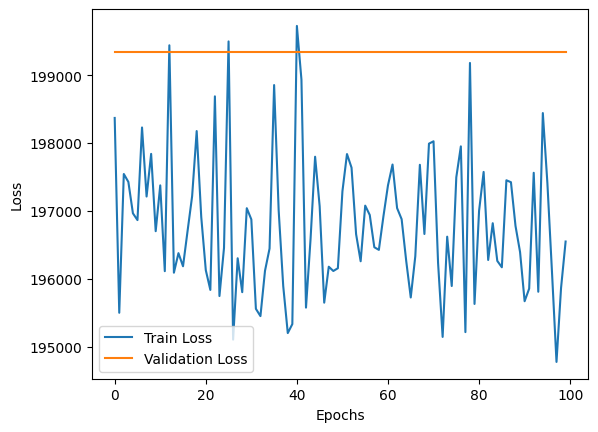

In [27]:
# Plot training and validation loss
plt.plot(train_losses, label='Train Loss') # Training loss curve
plt.plot(val_losses, label='Validation Loss') # Validation loss curve
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


**2_C**

In [29]:
useful_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath',
               'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'LotFrontage', 'WoodDeckSF',
               'OpenPorchSF', 'ExterQual', 'Neighborhood', 'MSZoning', 'Alley', 'LotShape',
               'LandContour', 'Condition1', 'HouseStyle', 'MasVnrType', 'SaleCondition']
target_col = 'SalePrice'

# Select and copy relevant columns
df_train_prepro = df_train[useful_cols + [target_col]].copy()

# Fill missing values for numeric columns with mean
df_train_prepro[numeric_cols] = df_train_prepro[numeric_cols].fillna(df_train_prepro[numeric_cols].mean())

# Fill missing values for categorical columns with mode
for col in categorical_cols:
    df_train_prepro[col] = df_train_prepro[col].fillna(df_train_prepro[col].mode()[0])

# Define categorical features for one-hot encoding
categorical_features = ['ExterQual', 'Neighborhood', 'MSZoning', 'Alley', 'LotShape',
                        'LandContour', 'Condition1', 'HouseStyle', 'MasVnrType', 'SaleCondition']

# One-hot encoding for categorical features
df_train_prepro = pd.get_dummies(df_train_prepro, columns=categorical_features)

# Split dataset into features and target
X = df_train_prepro.drop(target_col, axis=1)
y = df_train_prepro[target_col]


In [30]:
# Split data and scale features
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled, X_val_scaled = scaler.fit_transform(X_train), scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor, y_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor, y_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# Create data loaders
train_loader, val_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True), DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, shuffle=False)


In [34]:
class MLP_extended(nn.Module):
    def __init__(self, input_size):
        super(MLP_extended, self).__init__()
        self.fc1, self.fc2, self.fc3, self.fc4, self.fc5, self.fc6 = (
            nn.Linear(input_size, 1024),
            nn.Linear(1024, 512),
            nn.Linear(512, 256),
            nn.Linear(256, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 1)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc6(self.relu(self.fc5(self.relu(self.fc4(self.relu(self.fc3(self.relu(self.fc2(self.relu(self.fc1(x)))))))))))
        return x


In [35]:
# Model initialization
model = MLP_extended(X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
train_losses, val_losses = [], []


In [38]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        rmse_loss = torch.sqrt(loss)
        rmse_loss.backward()
        optimizer.step()
        total_loss += rmse_loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            total_val_loss += torch.sqrt(loss).item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print training and validation loss
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


Epoch 1/100, Train Loss: 198369.2442, Val Loss: 199169.7344
Epoch 2/100, Train Loss: 193792.5403, Val Loss: 191221.5469
Epoch 3/100, Train Loss: 153124.9766, Val Loss: 79301.5500
Epoch 4/100, Train Loss: 62946.0674, Val Loss: 43503.1477
Epoch 5/100, Train Loss: 38014.6316, Val Loss: 35595.4359
Epoch 6/100, Train Loss: 31875.3947, Val Loss: 33017.8137
Epoch 7/100, Train Loss: 28590.9311, Val Loss: 32294.4344
Epoch 8/100, Train Loss: 27298.5802, Val Loss: 31398.7105
Epoch 9/100, Train Loss: 26743.4390, Val Loss: 31000.2176
Epoch 10/100, Train Loss: 24957.2213, Val Loss: 30574.5457
Epoch 11/100, Train Loss: 24844.2472, Val Loss: 31125.1031
Epoch 12/100, Train Loss: 23013.2255, Val Loss: 30207.0555
Epoch 13/100, Train Loss: 23147.9274, Val Loss: 30470.0777
Epoch 14/100, Train Loss: 22428.4646, Val Loss: 30660.7840
Epoch 15/100, Train Loss: 21264.7568, Val Loss: 32731.5094
Epoch 16/100, Train Loss: 21451.7051, Val Loss: 30336.5297
Epoch 17/100, Train Loss: 21057.4618, Val Loss: 30299.4375
E

MSE: 948082004.5211293
RMSE: 30790.940299398608
R² Score: 0.8763961298500222


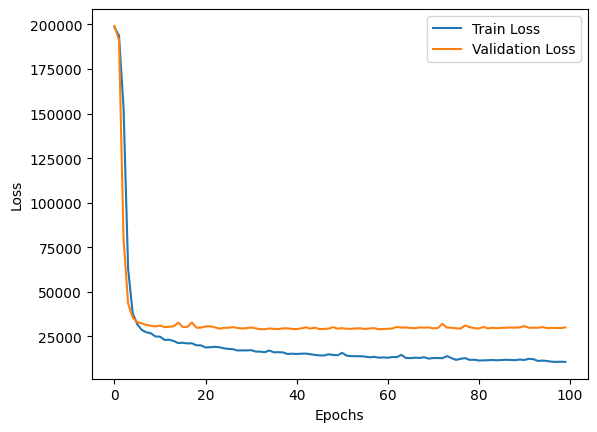

Total parameters: 782337


In [39]:
model.eval()
y_pred, y_true = [], []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        output = model(X_batch)
        y_pred.extend(output.view(-1).tolist())
        y_true.extend(y_batch.view(-1).tolist())

mse, rmse, r2 = mean_squared_error(y_true, y_pred), mean_squared_error(y_true, y_pred) ** 0.5, r2_score(y_true, y_pred)

print(f'MSE: {mse}\nRMSE: {rmse}\nR² Score: {r2}')

plt.plot(train_losses, label='Train Loss'); plt.plot(val_losses, label='Validation Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.show()

total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')
torch.save(model, 'model_complete.pth')
